# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#читаем файл
labels_data = pd.read_csv('/datasets/faces/labels.csv')

Выведем датасет:


In [3]:
labels_data

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Информация о документе:

In [4]:
labels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Проверим на наличие дубликатов и пропусков:

In [5]:
print('Количество дубликатов: ', labels_data.duplicated().sum())
print()
print('Количество пропусков: ', labels_data.isna().sum(), sep='\n')

Количество дубликатов:  0

Количество пропусков: 
file_name    0
real_age     0
dtype: int64


**Вывод:** Данный набор данных представляет из себя изображения в формате *.jpg*, упорядоченные согласно присвоенной нумерации. Кадому изображению соответствует ячейка с информацией о возрасте изображенного на нем человека. Дубликатов и пропусков значений в датасете не обнаружено. Размер выборки 7591 позиций, что достаточно мало для качественного обучения нейросети.

### Рассмотрим столбец с данными о возрасте.

Выведем статистические данные:

In [6]:
labels_data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

***Визуализируем распределение возрастов в выборке:***

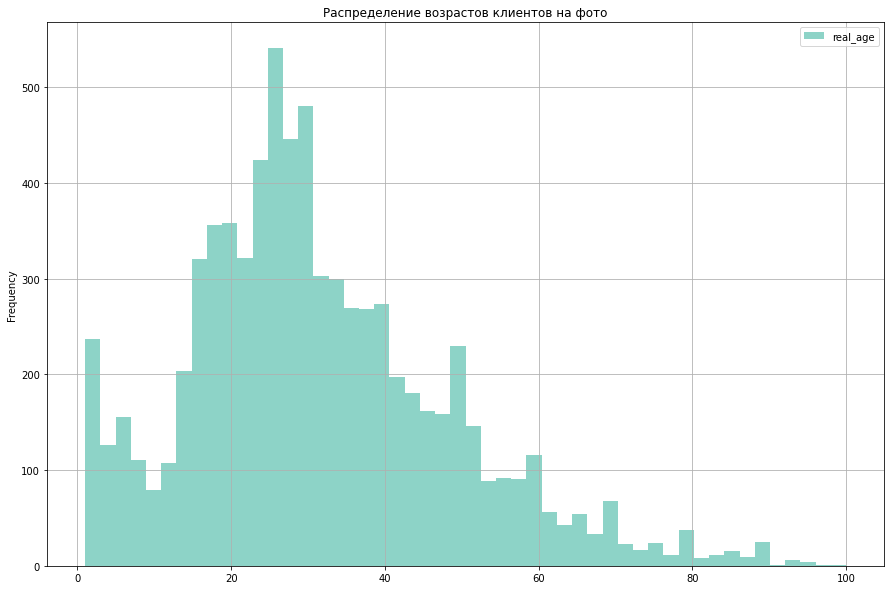

In [7]:
labels_data.plot(kind='hist', y='real_age', bins=50, figsize=(15, 10), grid=True, cmap="Set3",
                    title='Распределение возрастов клиентов на фото');

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='real_age'>

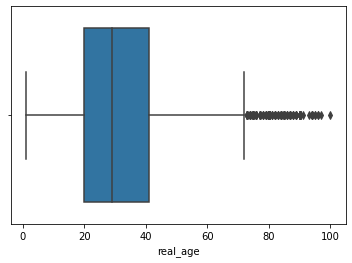

In [8]:
sns.boxplot(labels_data["real_age"])

**Вывод:**
- минимальный возраст в выборке - 1год, максимальный - 100 лет;
- медианное значение возраста = 29 лет;
- среднее значение возраста - 31 год;
- при визуализации видно, что распределение неравномерное, смещено в сторону медианы;
- в выборке присутствуют все возрастные группы начиная с детей от года;
- среди детей есть значительный выброс в  1 год, возможно, это результат округления более раннего возраста; 
- количество фото пожилых людей в выборке относительно небольшое.

Два последних пункта могут негативно сказаться на обучении модели. И если дети раннего возраста нам не интересны и, в теории, их можно не рассматривать как потенциальных покупателей, то недостаточное количество фото пожилых людей более критично и при реальной задаче выборку необходимо было бы расширить.

### Проанализируем изображения

Выведем несколько изображений:

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
features, target = next(train_gen_flow)

print(features.shape)

(32, 224, 224, 3)


Получаем 32 изображения размером 224 х 224 с тремя цветовыми каналами.

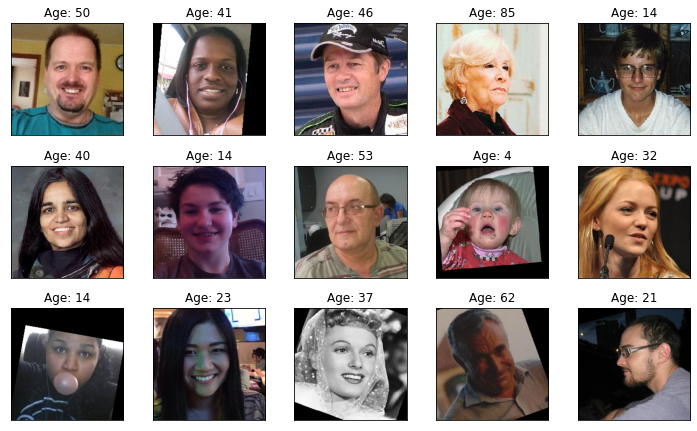

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: ' + str(target[i]))

**Вывод:** 
- есть и монохромные, и цветные изображения;
- ракурсы и окружение людей на фото неоднородно, есть изображения со смещением, низкого качества, с частично закрытым лицом, что может стать проблемой для обучения при изначально небольшой выборке.

### Общий вывод

Предобработка данных не требуется, создать модель по данному набору данных возможно. Однако, при анализе имеющегося датасета выявлены следующие моменты, которые могут повлиять на качество обучения:

- размер предоставленной выборки 7591 позиций, что достаточно мало для качественного обучения нейросети;
- среди детей имеется значительный выброс в  1 год; 
- количество фото пожилых людей в выборке относительно небольшое;
- есть и монохромные, и цветные изображения;
- ракурсы и окружение людей на фото неоднородно, есть изображения со смещением, низкого качества, с частично закрытым лицом.



## Обучение модели

С целью улучшения качества выборки возможно применение метода аугментации, т е добавление изображений с вращением, смещением, отраженных. Но в ограниченных условиях не буду добавлять(только горизонтальное отражение).
Для обучения была использована модель ResNet50 вместе с  Relu-активацией. В качестве функции потерь  использована Mean Squared Error, т.к. обучение идет быстрее. Качество модели оценивалось по метрике Mean Absolute Error, т.к. важен диапазон разброса предсказаний модели. Для автоматизации подбора шага  использован алгоритм Adam.

**Код обучения модели:**

```python
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
    
    
    

```

**Результат обучения модели, вывод на экран.**


```python

2022-08-03 20:48:44.163818: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-08-03 20:48:44.371910: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-08-03 20:48:47.963926: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-03 20:48:48.641385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-03 20:48:48.641464: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-03 20:48:48.641495: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-03 20:48:48.714224: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-03 20:48:48.742143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-03 20:48:49.067347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-03 20:48:49.105590: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-03 20:48:49.105714: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-03 20:48:49.110257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-08-03 20:48:49.491742: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-08-03 20:48:49.519361: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-08-03 20:48:49.521228: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46cb240 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-03 20:48:49.521261: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-03 20:48:49.744096: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4751260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-03 20:48:49.744138: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-08-03 20:48:49.746540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-03 20:48:49.746601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-03 20:48:49.746612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-03 20:48:49.746643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-03 20:48:49.746654: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-03 20:48:49.746666: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-03 20:48:49.746677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-03 20:48:49.746685: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-03 20:48:49.750957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-08-03 20:48:49.752677: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-03 20:48:53.134270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-03 20:48:53.134321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-08-03 20:48:53.134333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-08-03 20:48:53.138891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-08-03 20:49:17.364906: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-03 20:49:19.649819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 70s - loss: 193.5157 - mae: 10.3374 - val_loss: 484.1257 - val_mae: 16.8293
Epoch 2/10
178/178 - 38s - loss: 100.5425 - mae: 7.6275 - val_loss: 435.6823 - val_mae: 15.7348
Epoch 3/10
178/178 - 38s - loss: 68.7212 - mae: 6.3428 - val_loss: 425.2488 - val_mae: 15.4154
Epoch 4/10
178/178 - 38s - loss: 44.6992 - mae: 5.1687 - val_loss: 172.7966 - val_mae: 10.0760
Epoch 5/10
Epoch 6/10
178/178 - 38s - loss: 31.8733 - mae: 4.3187 - val_loss: 92.5518 - val_mae: 7.2534
178/178 - 37s - loss: 23.5878 - mae: 3.7432 - val_loss: 81.2709 - val_mae: 6.7804
Epoch 7/10
178/178 - 38s - loss: 19.0531 - mae: 3.3677 - val_loss: 90.8062 - val_mae: 7.1029
Epoch 8/10
178/178 - 38s - loss: 15.0465 - mae: 2.9870 - val_loss: 81.5594 - val_mae: 6.8918
Epoch 9/10
178/178 - 37s - loss: 10.2888 - mae: 2.4753 - val_loss: 72.6747 - val_mae: 6.5013
Epoch 10/10
178/178 - 38s - loss: 8.4394 - mae: 2.2169 - val_loss: 87.5806 - val_mae: 7.0321
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 87.5806 - mae: 7.0321
Test MAE: 7.0321



```
    

## Анализ обученной модели

Получен результат метрики качества: ***MAE: 7.0321***. Для достаточно проблемного датасета неплохой результат. Использовано 10 эпох и не использованы доплнительные методы улучшения метрики(например, аугментация для увеличения объема выборки), чтобы оптимизировать время обучения в рамках самостоятельного проекта и обучения на сервере.

С учетом целей исследования, можно сказать, что полученный результат, в целом, достаточен, чтобы было возможно определение пренадлежности к обширной возрастной группе(и как следствие, выполняется первая задача исследования - есть возможность целевых рекомендаций товаров). Но так как имеется значительная погрешность, контролировать добросовестность кассиров при продаже алкоголя не представляется возможным, необходима работа по максимальному снижению погрешности(и в целом рассмотрение вопроса о целесообразности использования подобной технологии изолировано, все-таки, думаю, в действительности добиться высокой точности в такой задаче не так просто)

